In [ ]:
!pip install yfinance

#Data Acquisition

The code below is used to acquire stock data about SPY, which is an exchange-traded fund that tracks the S&P 500 index. SPY, which stands for Standard & Poor's Depositary Receipts, is a popular security that investors use to get broad exposure to the U.S. stock market. By analyzing the stock data of SPY, investors can gain insight into the performance of the S&P 500 index and make more informed decisions when it comes to their investments.

In [2]:
import math
import yfinance as yf
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler 
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

stock_data = yf.download('SPY', start='2017-01-01', end='2023-01-01')
stock_data.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2017-01-03 00:00:00-05:00,225.039993,225.830002,223.880005,225.240005,202.856522,91366500
2017-01-04 00:00:00-05:00,225.619995,226.750000,225.610001,226.580002,204.063339,78744400
2017-01-05 00:00:00-05:00,226.270004,226.580002,225.479996,226.399994,203.901260,78379000
2017-01-06 00:00:00-05:00,226.529999,227.750000,225.899994,227.210007,204.630753,71559900
2017-01-09 00:00:00-05:00,226.910004,227.070007,226.419998,226.460007,203.955307,46939700



#Visualize the Data
The code below is used to visualize the price history of the SPY stock. It creates a line graph with the dates on the x-axis and the prices on the y-axis. The line graph displays the closing prices of the SPY stock on each day, giving an overview of the stock’s performance over time. This visualization allows investors to quickly identify trends and make decisions about when to buy or sell the stock.

Text(0, 0.5, 'Prices ($)')

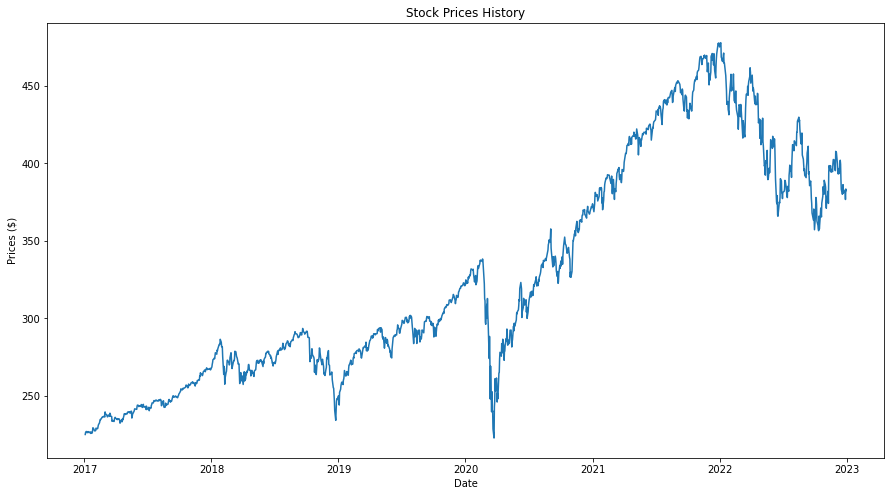

In [3]:
plt.figure(figsize=(15, 8))
plt.title('Stock Prices History')
plt.plot(stock_data['Close'])
plt.xlabel('Date')
plt.ylabel('Prices ($)')


#Data Prepreprocessing
The code below is used to preprocess data by organizing the data into a more usable format. This code will normalize the data by scaling the values to a range of 0 to 1. This allows the data to be more consistent, and it also helps with any potential outliers that may exist in the data. Additionally, the code is used to split the data into training and testing sets, which can be used to build and evaluate the model. This helps ensure that the model is trained and tested on different data sets, which helps with both accuracy and generalization.

In [4]:
close_prices = stock_data['Close']
values = close_prices.values
training_data_len = math.ceil(len(values)* 0.8)

scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(values.reshape(-1,1))

train_data = scaled_data[0: training_data_len, :]

x_train = []
y_train = []

for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])
    
x_train, y_train = np.array(x_train), np.array(y_train)

x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

In [5]:
test_data = scaled_data[training_data_len-60: , : ]
x_test = []
y_test = values[training_data_len:]

for i in range(60, len(test_data)):
  x_test.append(test_data[i-60:i, 0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

#LSTM
The code below is used to create a Long Short-Term Memory (LSTM) model, which is a type of Recurrent Neural Network (RNN). RNNs are a type of neural network used to process sequential data. An LSTM model is a specific type of RNN which is especially effective at modeling time-series data by adding a memory component. This memory component allows the model to store information from prior inputs which is used to inform future predictions. 

In [6]:
model = keras.Sequential()
model.add(layers.LSTM(100, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(layers.LSTM(100, return_sequences=False))
model.add(layers.Dense(25))
model.add(layers.Dense(1))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 60, 100)           40800     
                                                                 
 lstm_1 (LSTM)               (None, 100)               80400     
                                                                 
 dense (Dense)               (None, 25)                2525      
                                                                 
 dense_1 (Dense)             (None, 1)                 26        
                                                                 
Total params: 123,751
Trainable params: 123,751
Non-trainable params: 0
_________________________________________________________________


In [7]:
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(x_train, y_train, batch_size= 1, epochs=3)

Epoch 1/3
1148/1148 [==============================] - 22s 18ms/step - loss: 0.0020
Epoch 2/3
1148/1148 [==============================] - 21s 18ms/step - loss: 7.9268e-04
Epoch 3/3
1148/1148 [==============================] - 20s 18ms/step - loss: 6.8120e-04


In [8]:
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)
rmse = np.sqrt(np.mean(predictions - y_test)**2)
rmse

10/10 [==============================] - 1s 17ms/step


13.110424723846233

#Visualize Predictions

The code below is used to visualize the predicted prices of SPY. It plots the actual SPY value over time along with the predicted value. This allows us to see how well the model is predicting the stock prices, as well as any discrepancies between the two. The code utilizes a line chart to show the relationship between the two values and can be used to inform decisions about the stock.

<ipython-input-9-d92c50f720f0>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validation['Predictions'] = predictions


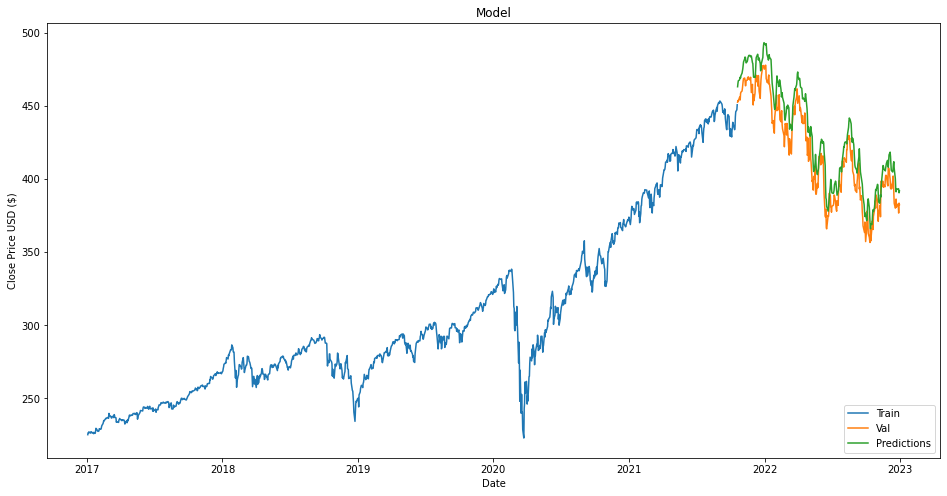

In [9]:
data = stock_data.filter(['Close'])
train = data[:training_data_len]
validation = data[training_data_len:]
validation['Predictions'] = predictions
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date')
plt.ylabel('Close Price USD ($)')
plt.plot(train)
plt.plot(validation[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()